Leonie Färber  
09.01.2024

# Physical Activity and Health in Europe

## Introduction  
Over the last decades, the rate of people living a more sedentary lifestyle in Europe has increased drastically which may have adverse health effects. This project analyzes the correlation between the average time spent on physical activity and the health of the population in European countries. To evaluate the health of a population two indicators are examined. On the one hand, the percentage of people reporting depressive symptoms is considered as an indicator of mental health. On the other hand, a self-report on perceived health is used to assess general health. 

## Methods  
### Datasources  
#### Datasource 1: Time spent on pyhsical activity
* Metadata URL: https://ec.europa.eu/eurostat/databrowser/view/hlth_ehis_pe2e$dv_300/default/table?lang=de
* Data URL: https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/HLTH_EHIS_PE2E/?format=SDMX-CSV&lang=en&label=label_only
* Data Type: CSV

Time spent on health-promoting (non-work-related) physical activity by country and year.

#### Datasource 2: Depressive symptoms
* Metadata URL: https://ec.europa.eu/eurostat/databrowser/view/hlth_ehis_mh1e/default/table?lang=de
* Data URL: https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/hlth_ehis_mh1e/?format=SDMX-CSV&lang=en&label=label_only
* Data Type: CSV

Current depressive symptoms by country and year.

#### Datasource 3: Self-report on general health
* Metadata URL: https://ec.europa.eu/eurostat/databrowser/view/hlth_silc_02/default/table?lang=de
* Data URL: https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/hlth_silc_02/?format=SDMX-CSV&lang=en&label=label_only
* Data Type: CSV

Self-report on health by country and year

### Selection of Data Sources
The choice of data sources was mainly influenced by the quality of data provided. Finding comparable data sources on health and movement that provide a similar amount of data for all included countries on a world wide scale proved difficult. Additionally, comparing the effect of movement on health drastically loses significance if inhabitants of the compared countries have vastly different lifestyles. So while choosing a more global scale for this project might generally be interesting it would require to check for multiple other correlating factors to be meaningful. This would go beyond the intended scope of this project. Therefore, this project limits its scope to a much smaller area. Europe provides comparable living standards and is of particular interest since inhabitants are on average becoming more sedentary due to e.g. the effects of digitalization. The chosen datasources allow us to make reasonable comparisons since the measurements were taken in the same time frame and from the same set of countries.  

### Data Pipeline
#### Extract
In the first step the data is extracted from the provided source files. The data pipeline uses the pandas library to read the data from the CSV files and convert it into a pandas DataFrame.
#### Transform
Some transformation steps have to be made for all datasets:  
* Drop any rows that have null values in the country or value (percentage of population) columns: Since these informations are crucial for the evaluation we must ensure a value is present.
* Standard values: For some columns there is only a singular value that is of interest to this project. Most of these values have been chosen to increase comparablity or decrease the number of data points to evaluate. Therefore this step ensures for the data to fit into a reasonable scope. These values include: 'annual' frequency, 'percentage' as unit, total values for sex and education (isced11) and 2014 as well as 2019 for the time period. We limit the time period to those two years since only one data set includes data points from more than these two.
* Drop generalized rows: Rows that provide values on all of Europe combined are too generalized to gain the insights we want
* Check for null value in the observation flag: If the observation flag is non null, the data is marked as uncertain due to sample size and other issues.
* Drop any columns that we just normalized as well as any columns containing metadata (such as DATAFLOW and last_update)
* Rename columns for readability  

Other transformations are specific to each dataset:  
Physical activity data:  
* Drop any rows that have null values in the duration column: The duration column provides us with the information on activity and is thus crucial
* The age must be set to total (here 18 and above): this is similar for all datasets but the term describing total values varies
* Exclude overlapping values from duration: Some duration labels are included in others and must therefore be removed before calculating an average duration
* Transform string labels for durations to numbers: The durations are given in intervals and named as strings. To be able to calculate an average duration, they must be converted to floats. For this we select the mean as a representative value for each interval. This process decreases the accuracy of the data but is necessary for comparisons. This limitation is further addressed in the discussion section of this report.   

Mental health data:
* Drop rows with null values in health problems column (similar as above)
* Select total age (here 18 and above)
* Exclude 'depressive symptoms' value which combines both major as well as other depressive symptoms: Again this value is too genralized for our usage
* Transform labels to numbers: Set 0 to no symptoms since these are not recorded in the dataset. This allows us to make graphic comparisons later on  

General health data:
* Drop rows with null values in health levels column
* Select total age (here 16 and above): The age intervalls do not allow for taking out data between the ages of 16 and 17. This is another limitation set by the data since it is not entirely comparable to the other two data sets
* Drop rows that include summarized health levels to get rid of overlapping data
* Map health level labels to a numerical scale from -2 to 2: This again allows for averaging values, better comparisons and visualization

#### Load
After the data has been transformed, the last step is to load the results to their destination sqlite files. In this step the different data sources were not merged to increase flexibility for the interpretation of the data. By not merging data there are more options for joining and slicing the data.


## Results
### Preparation
#### Dependencies

In [1]:
%pip install pandas
%pip install 'SQLAlchemy==1.4.46'
%pip install matplotlib
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


#### Imports

In [2]:
import os
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import seaborn as sns

#### Load Data

In [3]:
# if data file does not exist, run pipeline
if not os.path.exists("../data/result.sqlite"):
    subprocess.run(["python", "pipeline.py"])

# connect to SQLite database
conn = sqlite3.connect('../data/result.sqlite')

# SQL queries
query_activity = '''
    SELECT country, year, SUM(duration_in_min * (percentage_of_population / 100)) AS activity
    FROM activity
    GROUP BY country, year
'''
query_general_health = '''
    SELECT country, year, SUM(general_health * (percentage_of_population / 100)) AS general_health
    FROM general_health
    GROUP BY country, year
'''
query_mental_health = '''
    SELECT country, year, SUM(depressive_symptoms * (percentage_of_population / 100)) AS depressive_symptoms
    FROM mental_health
    GROUP BY country, year
'''

# read DataFrames from the database
df_activity = pd.read_sql_query(query_activity, conn)
df_general_health = pd.read_sql_query(query_general_health, conn)
df_mental_health = pd.read_sql_query(query_mental_health, conn)

# close the database connection
conn.close()

# merge or concatenate the DataFrames
common_identifiers = ['country', 'year']
merged_df = pd.merge(df_activity, df_general_health, on=common_identifiers)
merged_df = pd.merge(merged_df, df_mental_health, on=common_identifiers)



### Analysis

#### Data Presentation
First, we will present each data category individually using box plots.
  
**General Health**  
The self report on general health was measured on a scale from -2 to 2 with the following use of labels:  
> -2: Very bad  
> -1: Bad  
> 0: Fair  
> 1: Good  
> 2: Very good  

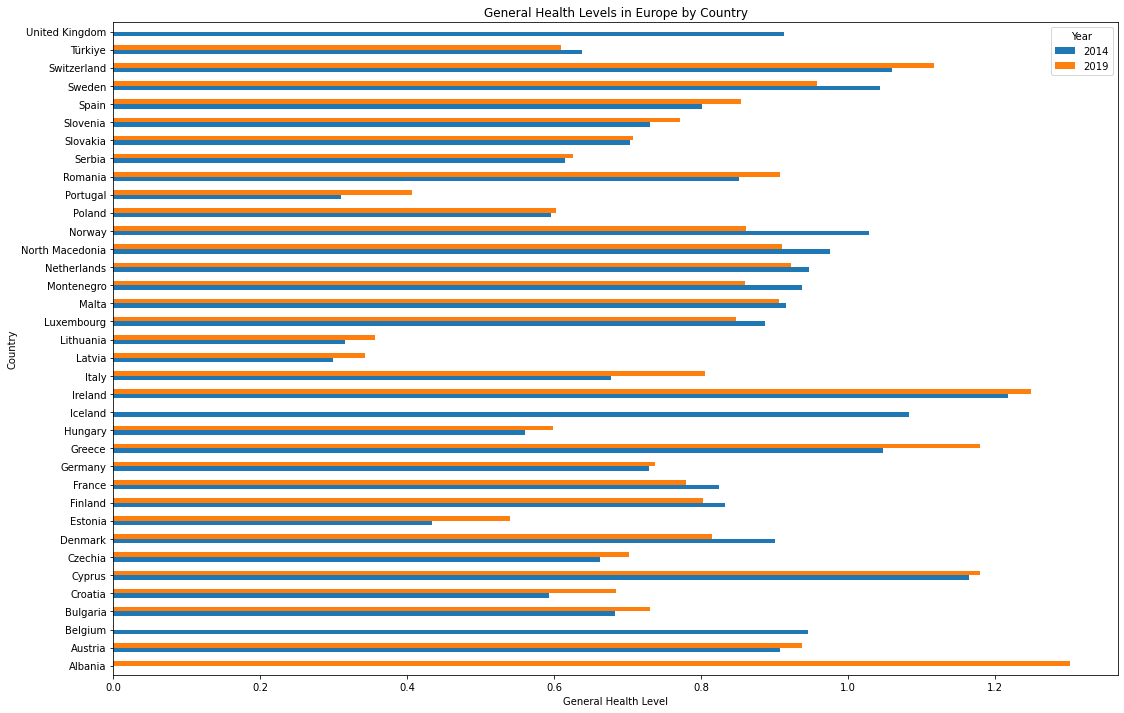

In [4]:
# pivoting the data to have years as columns and countries on the index
pivot_data = df_general_health.pivot(index='country', columns='year', values='general_health')

# plotting bar diagram
pivot_data.plot(kind='barh', rot=0, figsize=(18, 12))
plt.title('General Health Levels in Europe by Country')
plt.xlabel('General Health Level')
plt.ylabel('Country')
plt.legend(title='Year')
plt.show()



**Mental Health**  
The indicator of mental health in this project is the average severity of depressive symptoms. The severity of depressive symptoms is measured using the following scale:
> 0: No depressive symptoms  
> 1: Other depressive symptoms  
> 2: Major depressive symptoms  

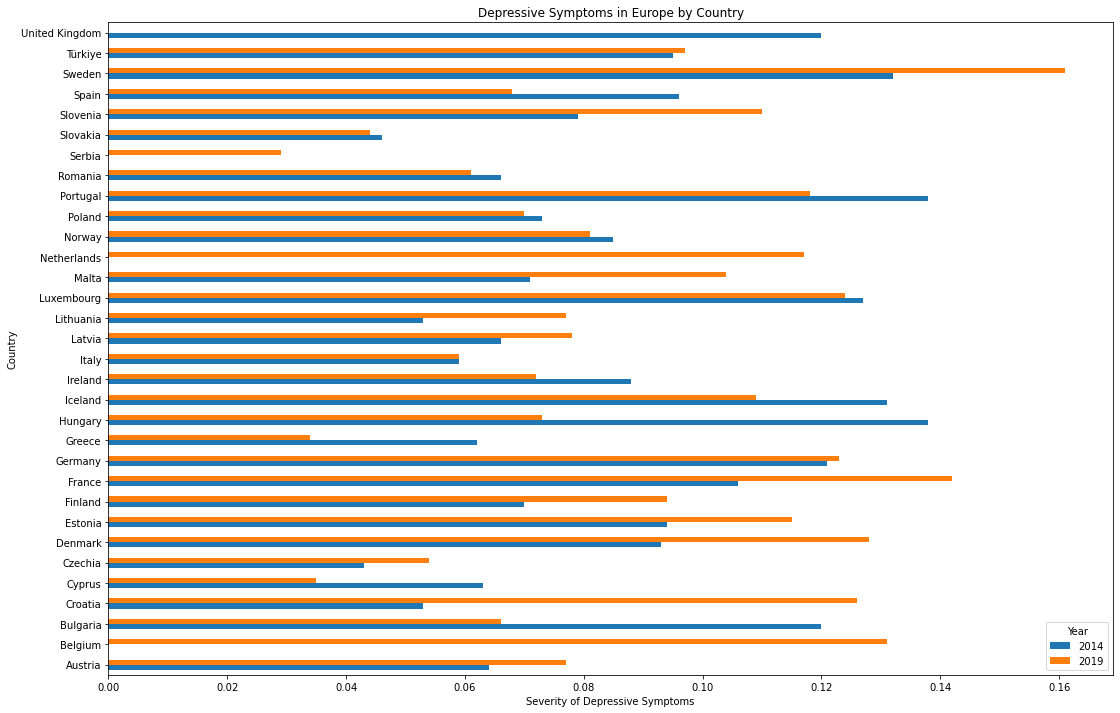

In [5]:

# pivoting the data to have years as columns and countries on the index
pivot_data = df_mental_health.pivot(index='country', columns='year', values='depressive_symptoms')

# plotting the bar diagram
pivot_data.plot(kind='barh', rot=0, figsize=(18, 12))
plt.title('Depressive Symptoms in Europe by Country')
plt.xlabel('Severity of Depressive Symptoms')
plt.ylabel('Country')
plt.legend(title='Year')
plt.show()

**Physical Activity**  
The physical activity was measured in minutes per week.

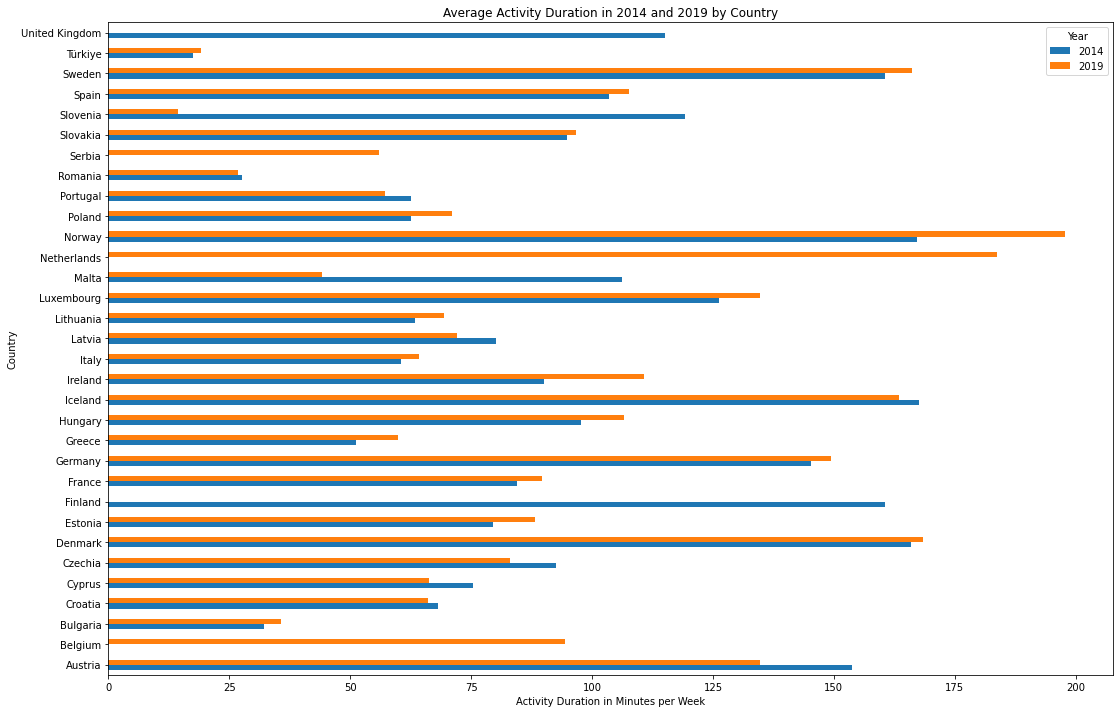

In [6]:
# pivoting the data to have years as columns and countries on the index
pivot_data = df_activity.pivot(index='country', columns='year', values='activity')

# plotting the bar diagram
pivot_data.plot(kind='barh', rot=0, figsize=(18, 12))
plt.title('Average Activity Duration in 2014 and 2019 by Country')
plt.xlabel('Activity Duration in Minutes per Week')
plt.ylabel('Country')
plt.legend(title='Year')
plt.show()

#### Data Distribution
To display the data distribution we use violin plots.

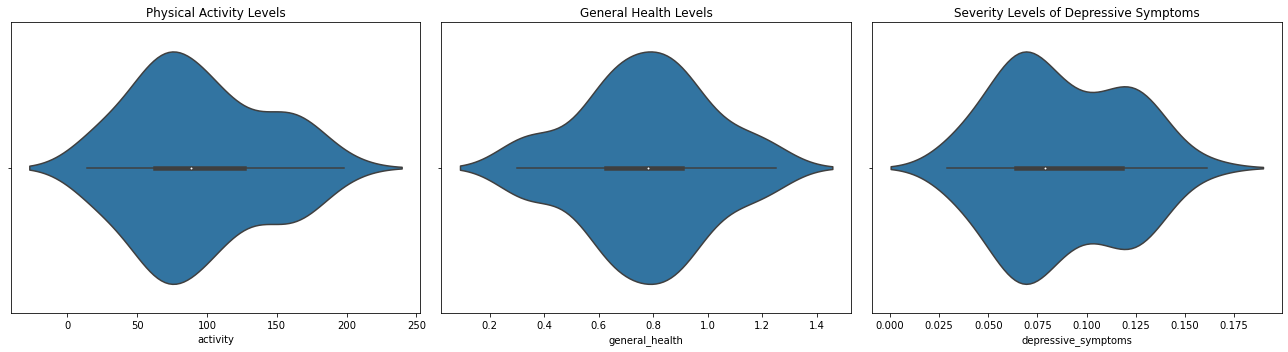

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.violinplot(x='activity', data=merged_df, ax=axes[0])
axes[0].set_title('Physical Activity Levels')

sns.violinplot(x='general_health', data=merged_df, ax=axes[1])
axes[1].set_title('General Health Levels')

sns.violinplot(x='depressive_symptoms', data=merged_df, ax=axes[2])
axes[2].set_title('Severity Levels of Depressive Symptoms')

plt.tight_layout()
plt.show()

#### Data Correlation
To evaluate possible correlations we draw scatter plots of all variable combinations. To increase the legibility of the diagrams the data poins were not annotated. For an overview on specific countries please refer to the data presentation section of this report.

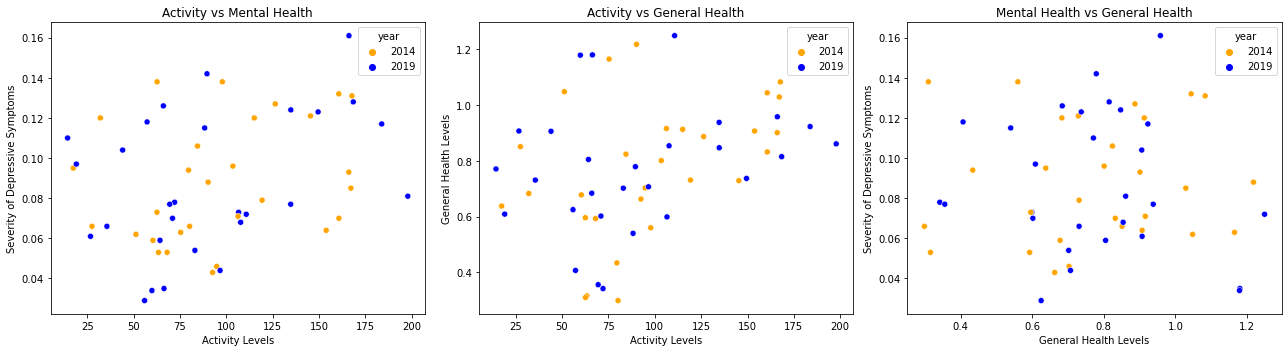

In [8]:
# create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# scatter plot activit x mental
sns.scatterplot(x='activity', y='depressive_symptoms', hue='year', palette={2014: 'orange', 2019: 'blue'}, data=merged_df, ax=axes[0])
axes[0].set_title('Activity vs Mental Health')
axes[0].set_xlabel('Activity Levels')
axes[0].set_ylabel('Severity of Depressive Symptoms')

# scatter plot activity x general
sns.scatterplot(x='activity', y='general_health', hue='year', palette={2014: 'orange', 2019: 'blue'}, data=merged_df, ax=axes[1])
axes[1].set_title('Activity vs General Health')
axes[1].set_xlabel('Activity Levels')
axes[1].set_ylabel('General Health Levels')

# scatter plot mental x general
sns.scatterplot(x='general_health', y='depressive_symptoms', hue='year', palette={2014: 'orange', 2019: 'blue'}, data=merged_df, ax=axes[2])
axes[2].set_title('Mental Health vs General Health')
axes[2].set_xlabel('General Health Levels')
axes[2].set_ylabel('Severity of Depressive Symptoms')

plt.tight_layout()
plt.show()


The correlation coeficients can be further displayed in a heat map:

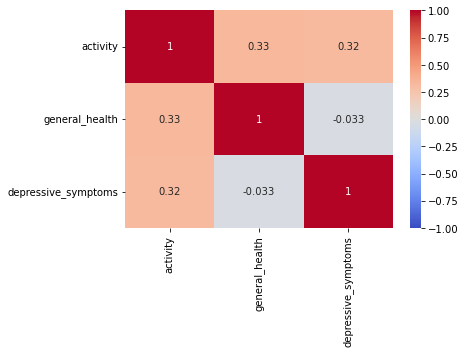

In [9]:
correlation_matrix = merged_df[['activity', 'general_health', 'depressive_symptoms']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

## Discussion

The raw data shows a very slight upwards trend from 2014 to 2019 in countries with increasing general health and a very slight downwards trend for mental health. For physical acitivity there is also a slight majority of countries experiencing an increase in activity. However since we can only draw comparisons between two years, these trends are too small to be significant. In addition there are countries with only one measurement which makes any noticeable trends even more insignificant. It would be interesting to look at a larger scale dataset to allow for more insight on pan-European developments over time.  
The distribution of data points shows that the variance in general health data is somewhat low. The data points range betwen 0 and 1.5 even though the scale goes from -2 to 2. This was to be expected since we specifically chose Europe for its relativliy similar standard of living between countries. On the one hand this allows us to calculate more exact correlation coefficients since some other correlating factors can be excluded from further consideration. On the other hand this somewhat limits the correlations we can see since the range of data points does not cover the full general health scale. For any further evaluations we have to consider that any correlation that we may find can only be applicable in the range of fair to (very) good health.  
When looking at the scatter plots we can see some slight trends for correlation between activity and health. To better evaluate this we displayed the correlation coefficients in a heat map. A correlation coefficient of 0.32 and 0.33 in the context of psychology and health would generally be considered a weak to moderate positive correlation. This suggests that there is a discernible relationship between the two variables, but the association is not extremely strong. For the correlation between activity and general health, a coefficient of 0.33 might indicate that individuals who engage in higher levels of physical activity tend to have moderately better general health scores. However, the relationship is not strong enough to make precise predictions about one variable based on the other. This outcome somewhat fits our expectations and the general narrative in society. Even though we would have wished for a more concise outcome.  
The correlation between mental health and activity seems similar to the above correlation. However, it has to be interpreted differently. Here we have a 0.32 correlation coefficient. Which means a weak to moderate corelation between physical activity and severity of depressive symptoms. Therefore, this is not an outcome we would expect or that other research on this topic would suggest.  
Another interesting point is that correlation coefficient suggests that there is no correlation between general health and mental health. This is also a somewhat unexpected outcome.  
Altogether, what can we learn from these outcomes? Mostly how difficult answering the question of correlation and causality is in the field of psychology and health. But it is interesting to evaluate why our outcomes partially differ from recent research. 
To obtain better results we must consider many more correlating factors. These may include gender, age, education, etc. Also we must look at the premise of our survey. The general health was evalutated using self report on a relatively vague scale. Also, it was the only data set gathering data from the age of 16 not 18. The measurements for activity duration were averaged twice. Once concerning the labels and once over each country.This makes the data points less reliable. Furthermore, mental health is not only comprised of depression. Including other mental health diseases and factors would allow for a more precise discussion about mental health and physical activity. Additionaly, there are multiple other factors that could be considered in future work. Increasing sample sizes, decreasing the interval between measurements and collecting data on a personal level would provide more precise outcomes.  
Generally speaking, many more insights can be gathered in the still relatively young field of health psychology. And while finding plausible correlations might prove difficult in some areas as shown above, modern society could benefit immensely from understanding the links between health and lifestyle.